## DATA AND MACHINE LEARNING OPERATIONS (DATAOPS AND MLOPS) 
### PhD Course AAU
#### ASSIGNMENT 3B: Data Augmentation using DeltaPy package
#### Kashif Rabbani
Explore possibilities to apply data augmentation to tabular data based on the DeltaPy package: https://github.com/firmai/deltapy. Perform a task of your choice (e.g., classification) by selecting a tabular dataset and evaluating any performance improvements resulting from the use of techniques such transforming, interacting, mapping, extracting, or synthesising.

**Solution:**
Our solution consists of two parts, i.e., Part 1: Data Preparation (where we download a tabular dataset and prepare test/train dataset) and Part 2: Modeling (where we create models and evaluate their performance, then we extend those models by performing data standardization, normalization, and augmentation; and evaluate the performance again).

## 1: Data Preparation
We have downloaded and prepared the UCWe Wine Quality Dataset. This dataset contains separate CSV files for red and white wine and their quality (`winequality-red.csv` and `winequality-white.csv` files). Next, We have fused these datasets into a single matrix with an additional feature (0/1) for the type (red or white), computed meaningful summary statistics for semi-manual data validation. Lastly, We have split the data into train and test datasets, and further divided the train data into train and validation sets.  In order to persist the train, validation, and test datasets, We have saved them as parquet files.


fixed acidity
volatile acidity
citric acid
residual sugar
chlorides
free sulfur dioxide
total sulfur dioxide
density
pH
sulphates
alcohol
quality
label
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    6497.000000       6497.000000  6497.000000     6497.000000   
mean        7.215307          0.339666     0.318633        5.443235   
std         1.296434          0.164636     0.145318        4.757804   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  6497.000000          6497.000000           6497.000000  6497.000000   
mean      0.056034            30.525319            1

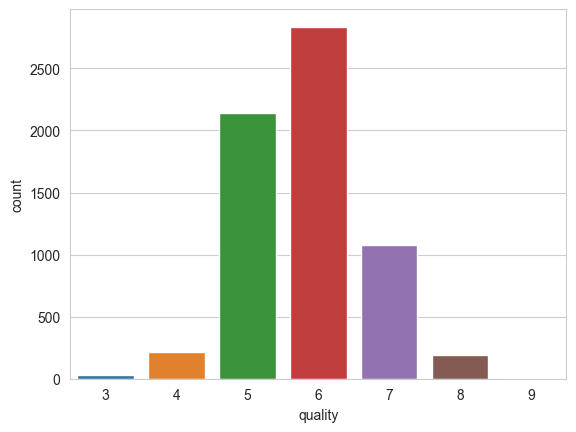

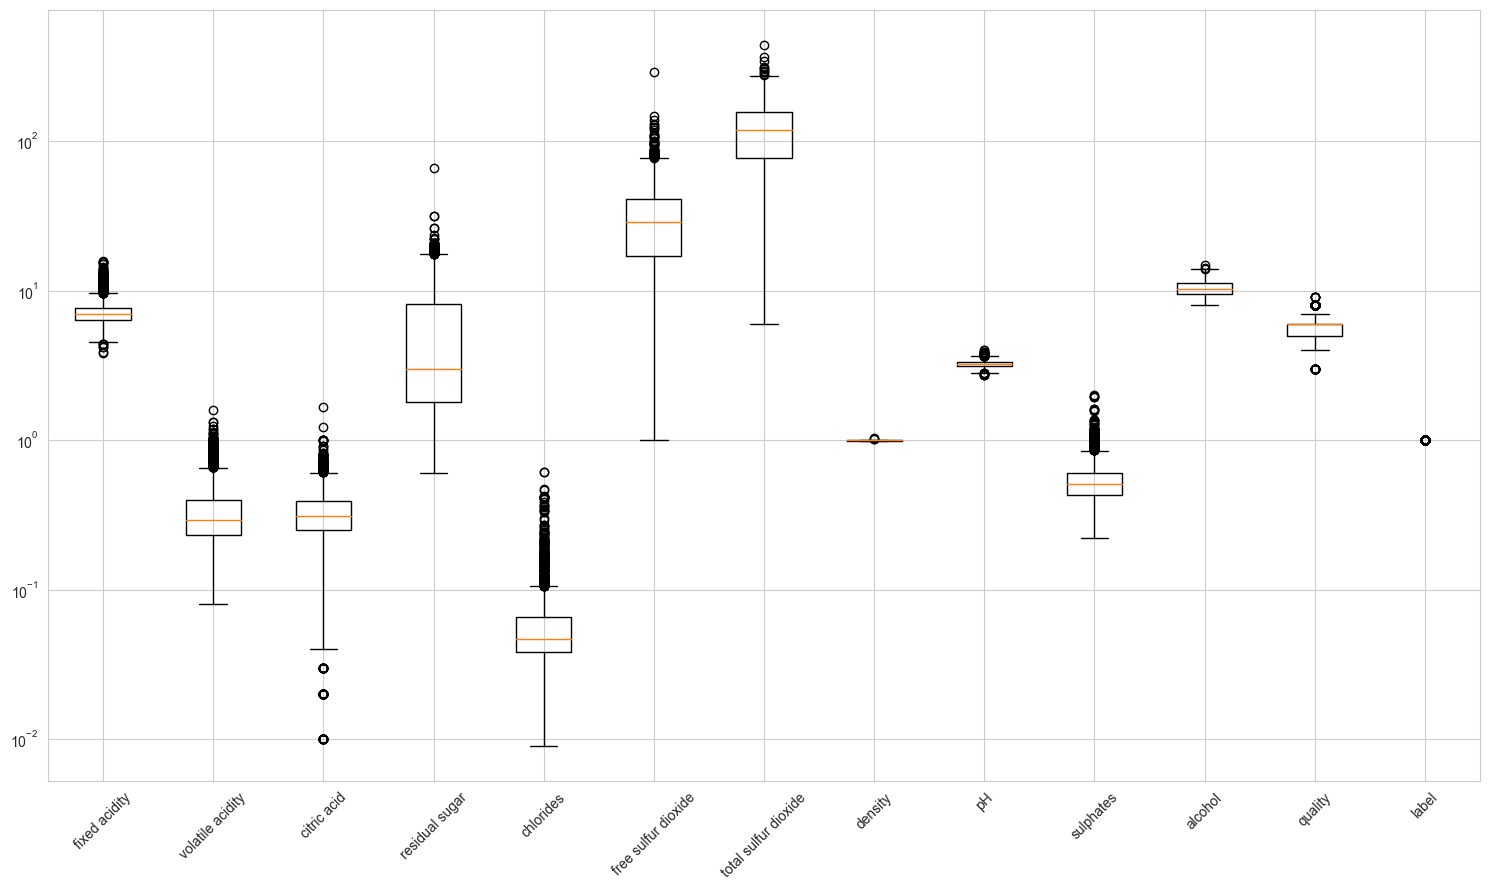

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split

if __name__ == '__main__':
    # Set pandas and seaborn display options
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.max_columns', None)

    # Load data
    wine_red = pd.read_csv('winequality-red.csv', sep=';')
    wine_white = pd.read_csv('winequality-white.csv', sep=';')

    # Insert labels
    wine_red['label'] = 1
    wine_white['label'] = 0

    # Combine wine datasets
    wine_all = pd.concat((wine_red, wine_white), axis=0)

    # Print all features of dataset
    for column in wine_all.columns.to_list():
        print(column)

    # Describe data with simple statistics
    print(wine_all.describe())

    # Plot quality
    sns.countplot(x='quality', data=wine_all)

    fig, ax = plt.subplots(figsize=(15, 9))
    wine_columns = wine_all.columns.to_list()
    pos = np.arange(len(wine_columns)) + 1
    ax.boxplot(wine_all.to_numpy(), positions=pos, labels=wine_columns)

    plt.yscale('log')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Split data
    X = wine_all.loc[:, wine_all.columns != 'label']
    Y = wine_all['label']

    X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, stratify=Y, test_size=0.2, random_state=42)
    X_valid, X_test, Y_valid, Y_test = train_test_split(X_valid, Y_valid, stratify=Y_valid, test_size=0.5, random_state=42)

    train = pd.concat((X_train, Y_train), axis=1)
    valid = pd.concat((X_valid, Y_valid), axis=1)
    test = pd.concat((X_test, Y_test), axis=1)

    # Persist datasets , requires  pyarrow and fastparquet
    train.to_parquet('train.parquet')
    valid.to_parquet('valid.parquet')
    test.to_parquet('test.parquet')



## 2: Modeling with standardization, normalization, and augmentation
Here We read the prepared datasets, and train two predictive models on the train set for (1) predicting the wine quality (using regression), and (2) predicting the wine type (using classification), along with evaluation of these models—with appropriate evaluation metrics—on the hold-out test set.

Lastly, We extend these ML pipelines with standardization, normalization, and **augmentation** using deltaPy library.

### Details:
We used RFC (Random Forest Classifier) and MLP (Multilayer Perceptron) classifiers to predict the wine quality and wine type using regression and classification respectively. We evaluated these models on hold-out test set and measured the accuracy and R^2 values. Results are shown below:

    - Wine Quality Prediction (Regresion):
        R^2-RFC = 0.4836
        R^2-MLP = 0.2707
    - Wine Type Prediction (Classifcation):
        Accuracy-RFC = 0.9954
        Accuracy-MLP = 0.9862

ML Pipelines Extension: Further We extended our pipeline by standardizing, normalizing, and removing outliers.
We used functionalities from *sklearn.preprocessing* library to standardize using StandardScaler() and normalize using MinMaxScaler() methods.
Additionally, we used methods from **deltaPy** (https://github.com/firmai/deltapy) library for outliers detection and removal.
We found outliers thresholds (proportion of outliers) for 'chlorides', 'citric acid', and 'residual sugar' features based on training dataset and removed data outside those thresholds from training, validation, and label datasets.

Below we show accuracy and R^2 using extended pipeline:

    - Wine Quality Prediction (Regresion):
        R^2-RFC = 0.4787
        R^2-MLP = 0.3508
    - Wine Type Prediction (Classifcation):
        Accuracy-RFC = 0.9984
        Accuracy-MLP = 0.9984

**Insights:** Results show that extending our proposed ML pipeline with standardization, normalization, and augmentation (outlier removal) improves the accuracy and R^2 of models on test data.

*Note: We were not able to install DeltaPy library as a package due to unknown issues. Therefore, We explored the library code and used the required methods for detecting outliers.*

In [8]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


# Use of methods from DeltaPy library https://github.com/firmai/deltapy/blob/master/deltapy/transform.py
def outlier_detect(data, col, threshold=1, method="IQR"):
    if method == "IQR":
        IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
        Lower_fence = data[col].quantile(0.25) - (IQR * threshold)
        Upper_fence = data[col].quantile(0.75) + (IQR * threshold)
    if method == "STD":
        Upper_fence = data[col].mean() + threshold * data[col].std()
        Lower_fence = data[col].mean() - threshold * data[col].std()
    if method == "OWN":
        Upper_fence = data[col].mean() + threshold * data[col].std()
        Lower_fence = data[col].mean() - threshold * data[col].std()
    if method == "MAD":
        median = data[col].median()
        median_absolute_deviation = np.median([np.abs(y - median) for y in data[col]])
        modified_z_scores = pd.Series([0.6745 * (y - median) / median_absolute_deviation for y in data[col]])
        outlier_index = np.abs(modified_z_scores) > threshold
        print('Num of outlier detected:', outlier_index.value_counts()[1])
        print('Proportion of outlier detected', outlier_index.value_counts()[1] / len(outlier_index))
        return outlier_index, (median_absolute_deviation, median_absolute_deviation)

    para = (Upper_fence, Lower_fence)
    tmp = pd.concat([data[col] > Upper_fence, data[col] < Lower_fence], axis=1)
    outlier_index = tmp.any(axis=1)
    print('Num of outlier detected:', outlier_index.value_counts()[True])
    print('Proportion of outlier detected', outlier_index.value_counts()[True] / len(outlier_index))

    return para


# Inspired from https://github.com/firmai/deltapy/blob/master/deltapy/transform.py
def windsorization(data, col, para, strategy='both'):
    data_copy = data.copy(deep=True)
    if strategy == 'both':
        data_copy.drop(data_copy[data_copy[col] > para[0]].index, inplace=True)
        data_copy.drop(data_copy[data_copy[col] < para[1]].index, inplace=True)
    elif strategy == 'top':
        data_copy.drop(data_copy[data_copy[col] > para[0]].index, inplace=True)
    elif strategy == 'bottom':
        data_copy.drop(data_copy[data_copy[col] < para[1]].index, inplace=True)
    return data_copy


def load_classification():
    # Load whole dataset
    train = pd.read_parquet('train.parquet')
    valid = pd.read_parquet('valid.parquet')
    test = pd.read_parquet('test.parquet')

    return train, valid, test


def load_regression():
    # Load whole dataset
    train = pd.read_parquet('train.parquet')
    valid = pd.read_parquet('valid.parquet')
    test = pd.read_parquet('test.parquet')

    # Split classification datasets into features and labels
    train_X = train.loc[:, train.columns != 'quality']
    train_Y = train['quality']
    valid_X = valid.loc[:, valid.columns != 'quality']
    valid_Y = valid['quality']
    test_X = test.loc[:, test.columns != 'quality']
    test_Y = test['quality']

    return (train_X, train_Y), (valid_X, valid_Y), (test_X, test_Y)


def scale_dataframes(data_c):
    print('Fit standard scaler\n')
    s_scaler = StandardScaler()
    s_scaler = s_scaler.fit(data_c)

    return s_scaler


def split_data_label(data, label):
    # Split classification datasets into features and labels
    X = data.loc[:, data.columns != label]
    Y = data[label]

    return X, Y


def remove_outliers(train, valid, test):
    print('Removing Outliers')
    threshold = 2
    columns = ['chlorides', 'citric acid', 'residual sugar']
    for col in columns:
        print(f'\nOutliers in {col}:')
        para = outlier_detect(train, col, threshold=threshold)
        train = windsorization(train, col, para, strategy='both')
        valid = windsorization(valid, col, para, strategy='both')
        test = windsorization(test, col, para, strategy='both')

    return train, valid, test


def simple_ml_pipeline_c(train, test):
    # Split classification datasets into features and labels
    train_x, train_y = split_data_label(train, 'label')
    test_x, test_y = split_data_label(test, 'label')

    pipe_rfc_c = Pipeline([('rfc', RandomForestClassifier())])
    pipe_mlp_c = Pipeline([('mlp', MLPClassifier(max_iter=1000))])

    pipe_rfc_c.fit(train_x, train_y)
    score = pipe_rfc_c.score(test_x, test_y)
    print(f'RFC - Accuracy of test data: {round(score, 4)}')

    pipe_mlp_c.fit(train_x, train_y)
    score = pipe_mlp_c.score(test_x, test_y)
    print(f'MLP - Accuracy of test data: {round(score, 4)}')


def simple_ml_pipeline_r(train, test):
    # Split classification datasets into features and labels
    train_x, train_y = split_data_label(train, 'quality')
    test_x, test_y = split_data_label(test, 'quality')

    pipe_rfc_r = Pipeline([('rfc', RandomForestRegressor())])
    pipe_mlp_r = Pipeline([('rfc', MLPRegressor(max_iter=1000))])

    pipe_rfc_r.fit(train_x, train_y)
    score = pipe_rfc_r.score(test_x, test_y)
    print(f'RFC - R2 of test data: {round(score, 4)}')

    pipe_mlp_r.fit(train_x, train_y)
    score = pipe_mlp_r.score(test_x, test_y)
    print(f'MLP - R2 of test data: {round(score, 4)}')


def extended_ml_pipeline_c(train, test):
    # Split classification datasets into features and labels
    train_x, train_y = split_data_label(train, 'label')
    test_x, test_y = split_data_label(test, 'label')

    pipe_rfc_c = Pipeline([('scaler', StandardScaler()), ('minmax', MinMaxScaler()), ('rfc', RandomForestClassifier())])
    pipe_mlp_c = Pipeline([('scaler', StandardScaler()), ('minmax', MinMaxScaler()), ('mlp', MLPClassifier(max_iter=1000))])

    pipe_rfc_c.fit(train_x, train_y)
    score = pipe_rfc_c.score(test_x, test_y)
    print(f'RFC - Accuracy of test data: {round(score, 4)}')

    pipe_mlp_c.fit(train_x, train_y)
    score = pipe_mlp_c.score(test_x, test_y)
    print(f'MLP - Accuracy of test data: {round(score, 4)}')


def extended_ml_pipeline_r(train, test):
    # Split classification datasets into features and labels
    train_x, train_y = split_data_label(train, 'quality')
    test_x, test_y = split_data_label(test, 'quality')

    pipe_rfc_r = Pipeline([('scaler', StandardScaler()), ('minmax', MinMaxScaler()), ('rfc', RandomForestRegressor())])
    pipe_mlp_r = Pipeline([('scaler', StandardScaler()), ('minmax', MinMaxScaler()), ('rfc', MLPRegressor(max_iter=1000))])

    pipe_rfc_r.fit(train_x, train_y)
    score = pipe_rfc_r.score(test_x, test_y)
    print(f'RFC - R2 of test data: {round(score, 4)}')

    pipe_mlp_r.fit(train_x, train_y)
    score = pipe_mlp_r.score(test_x, test_y)
    print(f'MLP - R2 of test data: {round(score, 4)}')


if __name__ == '__main__':
    train, valid, test = load_classification()  # Load classification dataset

    print("Basic ML Pipeline for CLASSIFICATION ")
    simple_ml_pipeline_c(train, test)
    print("\nBasic ML Pipeline for REGRESSION")
    simple_ml_pipeline_r(train, test)

    train, valid, test = remove_outliers(train, valid, test)  # Outlier detection and removal

    print("\nExtended ML Pipeline for CLASSIFICATION with Outlier Removal + Standardization + Normalization")
    extended_ml_pipeline_c(train, test)

    print("\nExtended ML Pipeline for REGRESSION with Outlier Removal + Standardization + Normalization")
    extended_ml_pipeline_r(train, test)


Basic ML Pipeline for CLASSIFICATION 
RFC - Accuracy of test data: 0.9969
MLP - Accuracy of test data: 0.9862

Basic ML Pipeline for REGRESSION
RFC - R2 of test data: 0.4743
MLP - R2 of test data: 0.2322
Removing Outliers

Outliers in chlorides:
Num of outlier detected: 155
Proportion of outlier detected 0.029824898980180873

Outliers in citric acid:
Num of outlier detected: 80
Proportion of outlier detected 0.016168148746968473

Outliers in residual sugar:
Num of outlier detected: 8
Proportion of outlier detected 0.0016614745586708203

Extended ML Pipeline for CLASSIFICATION with Outlier Removal + Standardization + Normalization
RFC - Accuracy of test data: 0.9984
MLP - Accuracy of test data: 0.9967

Extended ML Pipeline for REGRESSION with Outlier Removal + Standardization + Normalization
RFC - R2 of test data: 0.4709
MLP - R2 of test data: 0.3437
